In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# 超参数设置
config = {
    "model_name": "resnet",  # 可选 "resnet" 或 "vgg"
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"


In [3]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size


In [4]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes


In [7]:
def train_model(model, device, train_loader, test_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_acc = 0.0
    no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Accuracy {train_acc:.4f}")

        if train_acc > best_acc:
            best_acc = train_acc
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered.")
                break
    return model, history


In [8]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 1/15 [00:30<07:06, 30.44s/it]

Epoch 1: Train Loss 1.0713, Accuracy 0.6674


 13%|█▎        | 2/15 [00:59<06:27, 29.81s/it]

Epoch 2: Train Loss 0.7280, Accuracy 0.7723


 20%|██        | 3/15 [01:29<05:54, 29.54s/it]

Epoch 3: Train Loss 0.6337, Accuracy 0.8022


 27%|██▋       | 4/15 [01:58<05:26, 29.64s/it]

Epoch 4: Train Loss 0.5799, Accuracy 0.8128


 33%|███▎      | 5/15 [02:33<05:14, 31.46s/it]

Epoch 5: Train Loss 0.5214, Accuracy 0.8352


 40%|████      | 6/15 [03:07<04:49, 32.15s/it]

Epoch 6: Train Loss 0.4830, Accuracy 0.8507


 47%|████▋     | 7/15 [03:41<04:24, 33.07s/it]

Epoch 7: Train Loss 0.4508, Accuracy 0.8566


 53%|█████▎    | 8/15 [04:11<03:44, 32.05s/it]

Epoch 8: Train Loss 0.4554, Accuracy 0.8570


 60%|██████    | 9/15 [04:33<02:52, 28.78s/it]

Epoch 9: Train Loss 0.4317, Accuracy 0.8649


 67%|██████▋   | 10/15 [04:54<02:12, 26.54s/it]

Epoch 10: Train Loss 0.3937, Accuracy 0.8805


 73%|███████▎  | 11/15 [05:16<01:39, 24.87s/it]

Epoch 11: Train Loss 0.4143, Accuracy 0.8726


 80%|████████  | 12/15 [05:37<01:11, 23.88s/it]

Epoch 12: Train Loss 0.3956, Accuracy 0.8808


 87%|████████▋ | 13/15 [05:59<00:46, 23.19s/it]

Epoch 13: Train Loss 0.3832, Accuracy 0.8795


 93%|█████████▎| 14/15 [06:19<00:22, 22.44s/it]

Epoch 14: Train Loss 0.3521, Accuracy 0.8926


100%|██████████| 15/15 [06:40<00:00, 26.73s/it]

Epoch 15: Train Loss 0.3611, Accuracy 0.8879


              precision    recall  f1-score   support

 Agriculture       0.92      0.93      0.93       160
     Airport       0.75      0.85      0.80       160
       Beach       0.99      0.89      0.94       160
        City       0.92      0.92      0.92       160
      Desert       0.96      0.93      0.95       160
      Forest       0.97      0.97      0.97       160
   Grassland       0.98      0.93      0.96       160
     Highway       0.94      0.77      0.85       160
        Lake       0.89      0.94      0.91       160
    Mountain       0.89      0.95      0.92       160
     Parking       0.98      0.94      0.96       160
        Port       0.94      0.97      0.95       160
     Railway       0.77      0.93      0.84       160
 Residential       0.92      0.96      0.94       160
       River       0.91      0.80      0.85       160

    accuracy                           0.91      2400
   macro avg       0.92      0.91      0.91      2400
weighted avg       0.92   

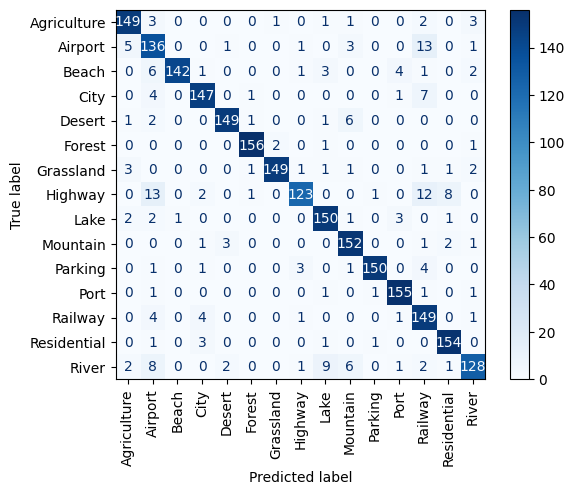

In [9]:
# 加载数据
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],
    sample_ratio=config["sample_ratio"]
)

# 初始化模型
model, input_size = initialize_model(
    model_name=config["model_name"],
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

# 数据增强
train_transform, test_transform = get_transforms(input_size)

# 构建Dataset和Loader
train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# 训练模型
model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],
    patience=5
)

# 评估
evaluate_model(model, test_loader, device, classes)
